# Calculs du processus de validation

In [1]:
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt
import scipy.fftpack as sc
import skimage.filters as skf
import skimage.morphology as skmorph
import skimage.exposure as ske
import skimage.transform as skt
from skimage import img_as_ubyte
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
import cv2

## Luminosité
### Calcul de la luminosité moyenne d'une image de référence

In [2]:
# Calculer la luminosité moyenne d'une image
ref_img = cv2.imread('ref_calculs.png')

# Convert to HSV
ref_img_hsv = cv2.cvtColor(ref_img, cv2.COLOR_BGR2HSV)

# Get the V channel
ref_img_v = ref_img_hsv[:, :, 2]

# Get the mean
ref_img_mean = np.mean(ref_img_v)

# Get the standard deviation
ref_img_std = np.std(ref_img_v)

print("Mean:", ref_img_mean)
print("Standard deviation:", ref_img_std)


Mean: 105.49251732528218
Standard deviation: 48.94530800154179


## Cadrage de l'image
### Evaluation de l'angle du cadre

### Evaluer angle de l'image d'origine

C:\Users\flore\AppData\Local\Temp\ipykernel_2308\3533743224.py:4: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (862, 1540, 3) looks like that of an RGB image.
  threshold = skf.threshold_otsu(ref_img)


Angle: (13,)


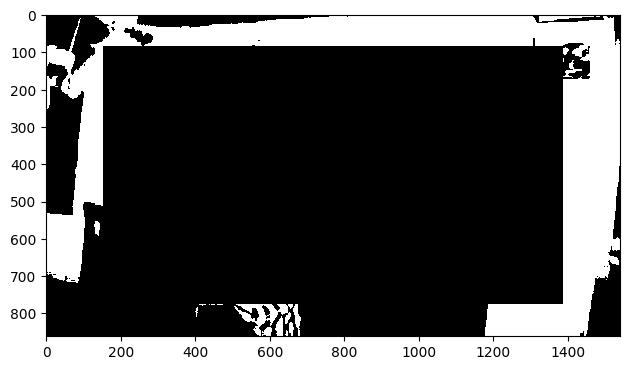

In [95]:
# Hough Transform need 2D tensor
ref_img = cv2.imread('ref_img.png')

threshold = skf.threshold_otsu(ref_img)
ref_img = rgb2gray(ref_img)
ref_img = img_as_ubyte(ref_img)
ref_img = ref_img > threshold

# Mettre les 3/4 de l'image à 0
ref_img[ref_img.shape[0]//10:ref_img.shape[0]*9//10,ref_img.shape[1]//10:ref_img.shape[1]*9//10] = 0

# calculer la transformée de Hough de l'image
hspace, angles, dists = skt.hough_line(ref_img)
hspace, angles, dists = skt.hough_line_peaks(hspace, angles, dists)

# Dessiner les lignes de Hough sur l'image
#for _, angle, dist in zip(*skt.hough_line_peaks(hspace, angles, dists)):
#    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
#    y1 = (dist - ref_img.shape[1] * np.cos(angle)) / np.sin(angle)
#    cv2.line(ref_img, (0, int(y0)), (ref_img.shape[1], int(y1)), (255, 0, 0), 1)

angles = angles*180/(np.pi)
good_angle = np.median(angles)
print("Angle:", angles.shape)

skio.imshow(ref_img)

In [92]:
# effectuer une rotation de 10 degrés de l'image
ref_img_rot = skt.rotate(ref_img, 10)

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Angle: (22,)


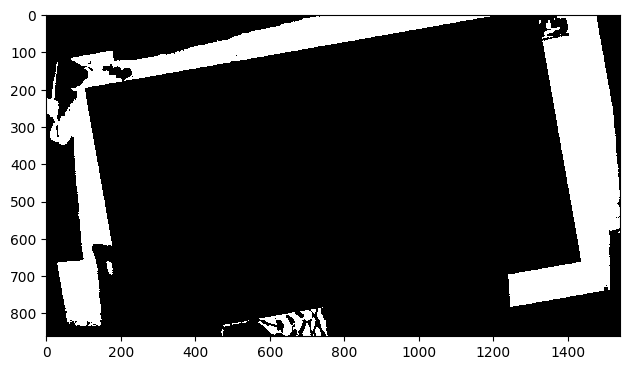

In [96]:

threshold = skf.threshold_otsu(ref_img_rot)
ref_img_rot = img_as_ubyte(ref_img_rot)
ref_img_rot = ref_img_rot > threshold

# calculer la transformée de Hough de l'image
hspace, angles, dists = skt.hough_line(ref_img_rot)
hspace, angles, dists = skt.hough_line_peaks(hspace, angles, dists)

angles = angles*180/(np.pi)
good_angle = np.median(angles)
print("Angle:", angles.shape)

skio.imshow(ref_img_rot)

Le nommbre de Hough peak detecté est + important si l'image a été rotatée. 

## Pourcentage de cadrage

### Image parfaite

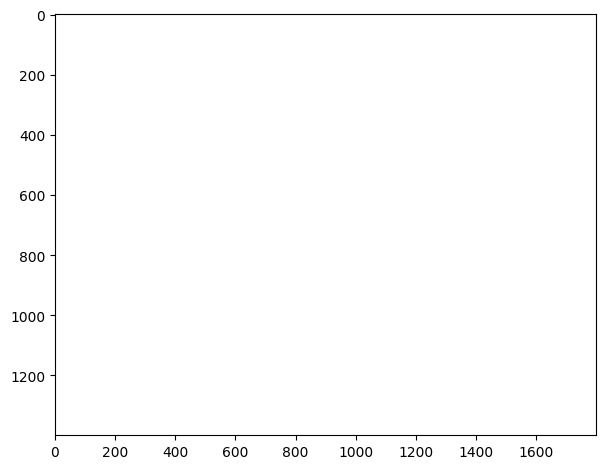

In [47]:
perfect_img = np.ones((1400, 1800)).astype(np.uint8)*255

skio.imshow(perfect_img)


### Image extraite

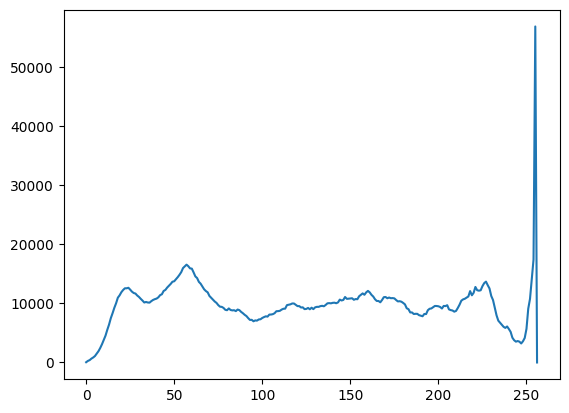

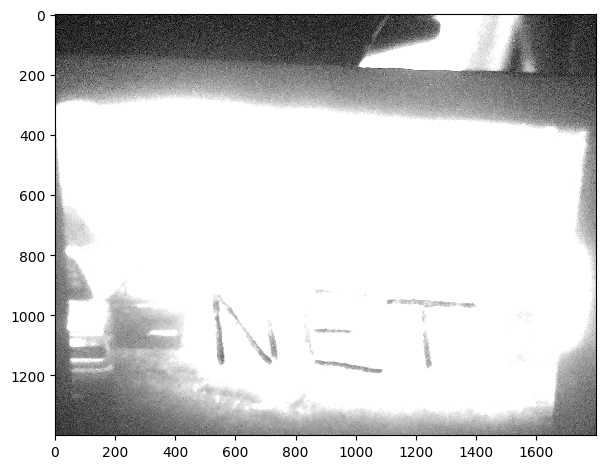

In [112]:
extracted_img = skio.imread('Essai_3_extracted_45.jpeg')
extracted_img = rgb2gray(extracted_img)
extracted_img = img_as_ubyte(extracted_img)

# afficher histogramme
hist, bins = np.histogram(extracted_img, 256, [0, 256])
hist = np.append(hist, 0)
plt.figure()
plt.plot(bins, hist, label='image extraite')

for i in range(extracted_img.shape[0]):
    for j in range(extracted_img.shape[1]):
        if extracted_img[i,j] > 100:
            extracted_img[i,j] = 255
        else:
            extracted_img[i,j] = extracted_img[i,j]*2.55

#threshold = 80
#extracted_img = extracted_img > threshold
plt.figure()
skio.imshow(extracted_img)
plt.show()


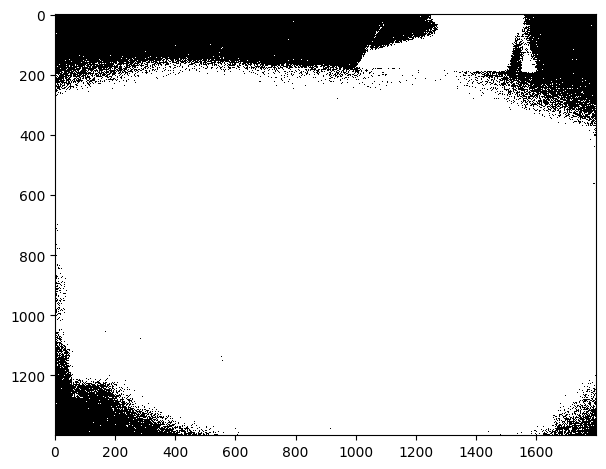

In [116]:
threshold = 110
#threshold = skf.threshold_otsu(extracted_img)
new_img = img_as_ubyte(extracted_img)
new_img = new_img > threshold
skio.imshow(new_img)

### Calcul du pourcentage de cadrage

In [124]:
size = 1400*1800
size2 = 1160*1748
print(size2/size) # zone inutile
percent = np.sum(extracted_img)/255 / size * 100
print("Percent:", percent)

# Calculer l'aire d'un quadrilatère quelconque à partir de ses 4 points 
def area(p1, p2, p3, p4):
    return 0.5 * np.abs(p1[0]*p2[1] + p2[0]*p3[1] + p3[0]*p4[1] + p4[0]*p1[1] - p2[0]*p1[1] - p3[0]*p2[1] - p4[0]*p3[1] - p1[0]*p4[1])

print(area([0,1], [0,3], [1, 4], [1,0]))

0.8046349206349206
Percent: 81.40554201680673
3.0


## Netteté de l'image

On calcule la variance du gradient de l'image. Fort variance --> image nette. 


### Calcul de la variance du gradient sur image floutée par un filtre gaussien

(882, 1424)


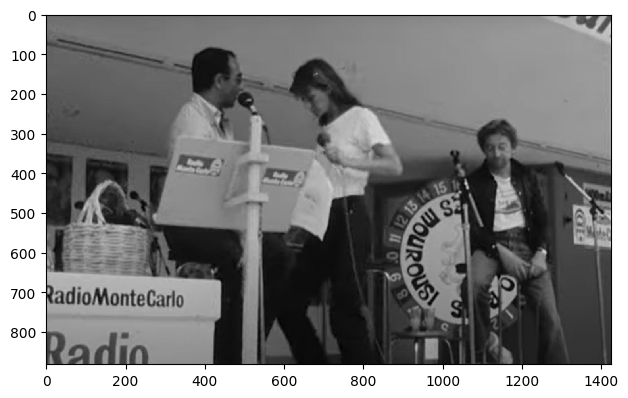

In [3]:
img = cv2.imread('ref_calculs.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
skio.imshow(img)

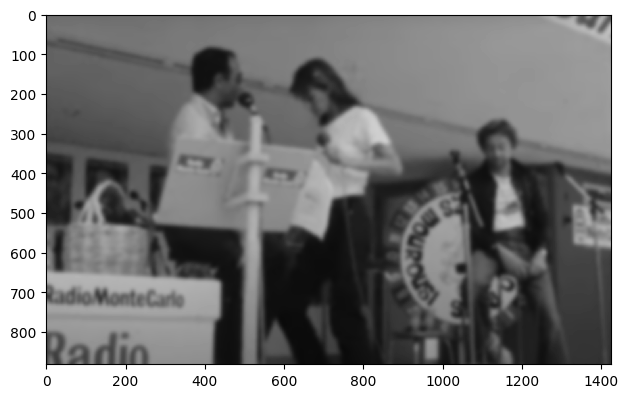

In [4]:
gauss_img = skf.gaussian(img, sigma=5)
skio.imshow(gauss_img)

In [5]:
def var_gradient(img):
# Calcul du gradient de l'img originale
    gx = skf.sobel_h(img)
    gy = skf.sobel_v(img)
    mag = np.sqrt(gx**2 + gy**2)
    var_mag = np.var(mag)
    print("Variance du gradient:", var_mag)

In [6]:
var_gradient(img)
var_gradient(gauss_img)

Variance du gradient: 0.001342510713089465
Variance du gradient: 0.0002095196920444768
